In this notebook we compare the translational mobility coefficients for a pair of passive spheres for 

 - PyStokes
 - linear solver: FTS Stokesian dynamics (F2s only)
 - linear solver: including all long-ranged traction modes
 
 to the exact solution given by **Goldmann, Cox and Brenner (1966)** using bipolar coordinates finding exact numerical values for the terminal speed of two spheres sedimenting, later re-used by **Batchelor (1971)**, and also **Ladd (1988)**. 
 
 Can further compare with results obtained using BEM by **Tran-Cong and Phan-Thien**. To be done...

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt

import pystokes
from linearSolveFTS import linearSolve_direct as linearSolveFTS
from linearSolve import linearSolve_direct as linearSolve
from linearSolveKrylov import linearSolve_krylov as krylov

import importlib

import simTools

In [2]:
PI = 3.14159265359

# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## passive particle
D0  = 0.      
S0  = 0.

## normalising factor: one-particle mobility
mu0 = 1./(6*PI*eta*b)

The results are compared at the nine fixed ratios $r/b$, where $r$ is the centre-to-centre distance: $2.0,\, 2.0049,\, 2.0907,\, 2.2553,\, 2.6749,\, 3.0862,\, 4.0,\, 6.0,\, 8.0$

In [3]:
rb = np.array([2.0, 2.0049, 2.0907, 2.2553, 2.6749, 3.0862, 4.0, 6.0, 8.0])

___________

### Exact results (normalised by $\mu_0$)

In [4]:
muPara = np.array([1.5500, 1.5494, 1.5376, 1.5160, 1.4662, 1.4236, 1.3472, 1.2427, 1.1847]) #force parallel to line of centers
muPerp = np.array([1.3799, 1.4027, 1.3933, 1.3648, 1.3029, 1.2586, 1.1950, 1.1273, 1.0947]) #force perpendicular to line of centers

____________

### PyStokes

In [5]:
pstk = pystokes.unbounded.Rbm(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

pstk_muPara = np.zeros(rb.shape[0])
pstk_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    pstk_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    pstk_muPerp[k] = v[4]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [6]:
pstk_muPara/muPara

array([1.0483871 , 1.04820011, 1.04580903, 1.04084827, 1.02886353,
       1.01996004, 1.00903726, 1.00214885, 1.00071484])

In [7]:
pstk_muPerp/muPerp

array([1.04174216, 1.02383002, 1.01445853, 1.00830671, 1.0027698 ,
       1.00113384, 1.00026151, 1.00001314, 1.00002426])

___________

### FTS linear solver

In [8]:
lsFTS = linearSolveFTS(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

lsFTS_muPara = np.zeros(rb.shape[0])
lsFTS_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    lsFTS.RBM(v, o, r, F, T, S)
        
    lsFTS_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    lsFTS.RBM(v, o, r, F, T, S)
        
    lsFTS_muPerp[k] = v[4]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [9]:
lsFTS_muPara/muPara

array([1.01064516, 1.01056976, 1.0101971 , 1.00934785, 1.00691264,
       1.00480553, 1.00208139, 1.00040843, 1.0001074 ])

In [10]:
lsFTS_muPerp/muPerp

array([1.03706673, 1.019318  , 1.01119299, 1.00648142, 1.00228371,
       1.00097488, 1.00024075, 1.00001229, 1.00002418])

______________

## full linear solver

In [11]:
ls = linearSolve(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

ls_muPara = np.zeros(rb.shape[0])
ls_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(5*Np)
D = np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    ls.RBM(v, o, r, F, T, S, D)
        
    ls_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ls.RBM(v, o, r, F, T, S, D)
        
    ls_muPerp[k] = v[4]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [12]:
ls_muPara/muPara

array([1.00815716, 1.00808349, 1.00775877, 1.00708938, 1.00532532,
       1.00379596, 1.00173563, 1.00036365, 1.00009822])

In [13]:
ls_muPerp/muPerp

array([1.03269812, 1.01508292, 1.00787517, 1.00432306, 1.00144892,
       1.00059606, 1.00015153, 1.00000347, 1.00002252])

______________

## krylov sovler

In [14]:
ky = krylov(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

ky_muPara = np.zeros(rb.shape[0])
ky_muPerp = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(6*Np)
D = np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    ky.RBM(v, o, r, F, T, S, D)
        
    ky_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    ky.RBM(v, o, r, F, T, S, D)
        
    ky_muPerp[k] = v[4]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1

In [15]:
ky_muPara/muPara

array([0.99689859, 0.99685078, 0.99693606, 0.99703653, 0.9975818 ,
       0.99828248, 0.99934741, 0.99987364, 0.99994689])

In [16]:
ky_muPerp/muPerp

array([1.00542334, 0.98869009, 0.9881186 , 0.99277972, 0.99769622,
       0.9990106 , 0.99979891, 0.99996946, 1.00001616])

Check whether krylov gives same as direct solver:

In [19]:
##ky_muPara/ls_muPara

In [20]:
##ky_muPerp/ls_muPerp

________________

## Plotting

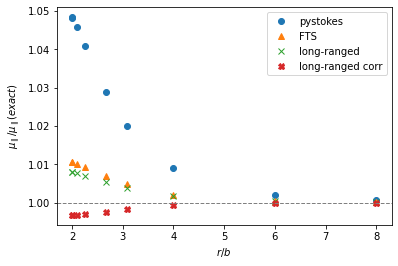

In [21]:
plt.plot(rb, pstk_muPara/muPara, label='pystokes', marker='o', linestyle="None")
plt.plot(rb, lsFTS_muPara/muPara, label='FTS', marker='^', linestyle="None")
plt.plot(rb, ls_muPara/muPara, label='long-ranged', marker='x', linestyle="None")
plt.plot(rb, ky_muPara/muPara, label='long-ranged corr', marker='X', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu_\parallel/\mu_\parallel(exact)$')
plt.legend()
plt.show()

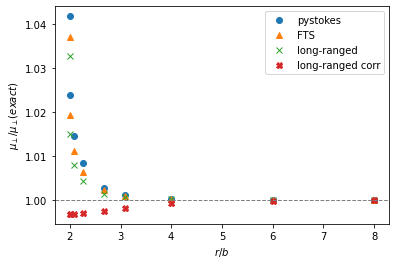

In [22]:
plt.plot(rb, pstk_muPerp/muPerp, label='pystokes', marker='o', linestyle="None")
plt.plot(rb, lsFTS_muPerp/muPerp, label='FTS', marker='^', linestyle="None")
plt.plot(rb, ls_muPerp/muPerp, label='long-ranged', marker='x', linestyle="None")
plt.plot(rb, ky_muPara/muPara, label='long-ranged corr', marker='X', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu_\perp/\mu_\perp(exact)$')
plt.legend()
plt.show()